In [54]:
! pip install kmodes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import plotly.express as px
warnings.filterwarnings('ignore')

%matplotlib inline

# Load and Describe Data

---------

## Load Data

Dataset yang kita gunakan adalah "Used Car Auction Prices" yang berasal dari Kaggle

In [2]:
dfcar = pd.read_csv('car_prices.csv', on_bad_lines="skip")
dfcar.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
291134,2014,Kia,Optima,LX,sedan,automatic,5xxgm4a78eg343229,ca,4.6,3656.0,white,beige,"kia motors america, inc",16200,17700,Tue Feb 17 2015 04:30:00 GMT-0800 (PST)
3698,2006,Ford,F-150,Lariat,SuperCrew,automatic,1ftpw14566fa59634,ca,2.6,153708.0,silver,gray,imans imports,9775,8500,Tue Jan 06 2015 12:30:00 GMT-0800 (PST)
424374,2014,Chevrolet,Cruze,LTZ,Sedan,automatic,1g1pg5sb4e7404822,il,4.0,24857.0,red,gray,gm remarketing,14250,14300,Thu Jun 11 2015 04:00:00 GMT-0700 (PDT)


#### List fitur pada dataset adalah sebagai berikut :

1. Year : Tanggal produksi dari mobil.
2. Make : Merk dari mobil.
3. Model : Edisi dari tiap merk mobil.
4. Trim : Versi trim dari mobil.
5. Body : Tipe bentuk dari mobil.
6. Transmission : Transmisi yang digunakan pada mobil.
7. VIN : Vehicle Identification Number.
8. State : Negara bagian tempat mobil dijual.
9. Condition : Kondisi dari mobil pada saat dijual.
10. Odometer : Jarak tempuh mobil semenjak tanggal manufacture.
11. Color : Warna eksterior dari mobil.
12. Interior : Warna interior dari mobil.
13. Seller : Penjual dari mobil (Car dealers).
14. **MMR : Manhiem Market Record, market yang memprediksi harga mobil.**
15. Sellingprice : Nilai jual mobil.
16. Saledate : Tanggal mobil dijual.

## Data Exploration

In [3]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


1. Total dari data ada 558811 entries
2. Tipe dari data int, float dan object, dan terlihat sudah sesuai dengan kolomnya. Namun, untuk kolom `saledate` tipe data yang awalnya 'object', dirasa perlu diubah ke date time.
3. Terdapat nilai Null pada beberapa fitur

In [4]:
# Mengecek null value
dfcar.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65353
vin                 0
state               0
condition       11794
odometer           94
color             749
interior          749
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

Terdapat 9 fitur yang memiliki Null value, yaitu `make`, `model`, `trim`, `body`, `transmission`, `condition`, `odometer`, `color`, `interior`. Perlu diadakan tindak lanjut di Data Cleaning

In [5]:
# Mengecek duplicated rows
dfcar.duplicated().sum()

0

Dataset tidak memiliki data duplikat sehingga tidak diperlukan penanganan.

In [5]:
# Mengkategorikan fitur sesuai dari tipe data
num = ['year', 'condition', 'odometer', 'mmr', 'sellingprice']
cat = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'saledate']

# Membatasi angka setelah koma hingga hanya 3 angka
pd.set_option('display.float_format', lambda x: '%.3f' % x)

dfcar[num].describe()

,year,condition,odometer,mmr,sellingprice
count,558811.000,547017.000,558717.000,558811.000,558811.000
mean,2010.039,3.425,68323.196,13769.325,13611.262
std,3.967,0.949,53397.753,9679.875,9749.657
min,1982.000,1.000,1.000,25.000,1.000
25%,2007.000,2.700,28374.000,7100.000,6900.000
50%,2012.000,3.600,52256.000,12250.000,12100.000
75%,2013.000,4.200,99112.000,18300.000,18200.000
max,2015.000,5.000,999999.000,182000.000,230000.000


1. `condition` memiliki value antara 1-5.
2. Nilai dari `odometer` terlihat memiliki jarak yang jauh antara min dan max dimana nilai min nya adalah 1 dan max nya hampir 1 juta. Tentu ini adalah hal yang terkesan janggal. Selain itu, nilai mean dan median nya juga terhitung sangat jauh yaitu 16000.
3. Secara keseluruhan, nilai `mmr` dan `sellingprice` tidak terlalu berbeda. Namun, nilai min-max dan mean-median nya sangat jauh, sehingga perlu diperhatikan lebih lanjut untuk tahap berikutnya.
4. Beberapa kolom di fitur numerical juga terdapat null value, sehingga perlu ditangani pada tahap berikutnya.

In [6]:
dfcar[cat].describe()

,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,548510,548412,548160,545616,493458,558811,558811,558062,558062,558811,558811
unique,96,973,1975,86,2,550296,38,20,17,14264,3745
top,Ford,Altima,Base,Sedan,automatic,wbanv13588cz57827,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,93554,19349,55817,199437,475914,5,82945,110970,244325,19693,5334


1. Dari data diatas, kita bisa melihat secara sekilas nilai apa yang paling teratas, sering muncul, dan berapa jumlah unique value dari masing-masing fitur.
2. Sebagai contoh, Ford merupakan `make` yang paling populer diantara 96 total brand lain. Selain itu, mobil `body` sedan juga termasuk yang paling favorit.
3. `transmission` automatic lebih dicari customer dibanding manual dengan jumlah lebih dari 90%.
4. Warna hitam tetap mendominasi baik di eksterior maupun interior.

----------

# EDA (Exploratory Data Analysis)

-------

## UNIVARIATE ANALYSIS 

Pada tahap EDA, kita akan menganalisis baik analisis univariate ataupun multivariate. Pada univariate analysis, kami menganalisis fitur-fitur yang sekiranya memberikan dampak besar terhadap harga jual mobil. Tak hanya itu, kami juga memvisualisasikan bagaimana persebaran data pada dataset baik ditinjau dari outliers, skewness, null value, dll.

### Unique Value From Some Features

In [8]:
dfcar['year'].unique()

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000, 1999, 1998, 1995, 1996, 1997, 1987,
       1994, 1993, 1992, 1989, 1991, 1990, 1986, 1985, 1988, 1984, 1982,
       1983], dtype=int64)

Semua value sudah sesuai, yaitu berupa angka yang dimulai dari tahun 1982 hingga 2015.

In [9]:
dfcar['make'].unique()

array(['Kia', 'BMW', 'Volvo', 'Nissan', 'Chevrolet', 'Audi', 'Ford',
       'Hyundai', 'Buick', 'Cadillac', 'Acura', 'Lexus', 'Infiniti',
       'Jeep', 'Mercedes-Benz', 'Mitsubishi', 'Mazda', 'MINI',
       'Land Rover', 'Lincoln', 'lincoln', 'Jaguar', 'Volkswagen',
       'Toyota', 'Subaru', 'Scion', 'Porsche', nan, 'bmw', 'Dodge',
       'FIAT', 'Chrysler', 'ford', 'Ferrari', 'Honda', 'GMC',
       'mitsubishi', 'Ram', 'smart', 'chevrolet', 'Bentley', 'chrysler',
       'pontiac', 'Pontiac', 'Saturn', 'Maserati', 'Mercury', 'HUMMER',
       'landrover', 'cadillac', 'land rover', 'mercedes', 'mazda',
       'toyota', 'lexus', 'gmc truck', 'honda', 'nissan', 'porsche',
       'Saab', 'Suzuki', 'dodge', 'subaru', 'Oldsmobile', 'oldsmobile',
       'hyundai', 'jeep', 'Isuzu', 'dodge tk', 'Geo', 'acura',
       'volkswagen', 'suzuki', 'kia', 'audi', 'Rolls-Royce', 'gmc',
       'maserati', 'mazda tk', 'mercury', 'buick', 'hyundai tk',
       'mercedes-b', 'vw', 'Daewoo', 'chev truck', 'f

Terdapat null value pada fitur `make`.
Value dari kolom `make` masih terlalu beragam dimana terdapat kata yang huruf awal kapital, kata yang berisi kapital semua, kata yang berisi lower case semua. Oleh karena itu, kita akan mengubah value nya menjadi lower case semua di tahap berikutnya. 

In [10]:
dfcar['trim'].unique()

array(['LX', '328i SULEV', 'T5', ..., 'pure', 'EWB', 'Power Wagon'],
      dtype=object)

Fitur `trim` memiliki lebih dari 1000 values sehingga unique value yang muncul hanya beberapa.

In [11]:
dfcar['body'].unique()

array(['SUV', 'Sedan', 'Convertible', 'Coupe', 'Wagon', 'Hatchback',
       'Crew Cab', 'G Coupe', 'G Sedan', 'Elantra Coupe', 'Genesis Coupe',
       'Minivan', nan, 'Van', 'Double Cab', 'CrewMax Cab', 'Access Cab',
       'King Cab', 'SuperCrew', 'CTS Coupe', 'Extended Cab',
       'E-Series Van', 'SuperCab', 'Regular Cab', 'G Convertible', 'Koup',
       'Quad Cab', 'CTS-V Coupe', 'sedan', 'G37 Convertible', 'Club Cab',
       'Xtracab', 'Q60 Convertible', 'CTS Wagon', 'convertible',
       'G37 Coupe', 'Mega Cab', 'Cab Plus 4', 'Q60 Coupe', 'Cab Plus',
       'Beetle Convertible', 'TSX Sport Wagon', 'Promaster Cargo Van',
       'GranTurismo Convertible', 'CTS-V Wagon', 'Ram Van', 'minivan',
       'suv', 'Transit Van', 'van', 'regular-cab', 'g sedan', 'g coupe',
       'hatchback', 'king cab', 'supercrew', 'g convertible', 'coupe',
       'crew cab', 'wagon', 'double cab', 'e-series van', 'regular cab',
       'quad cab', 'g37 convertible', 'supercab', 'extended cab',
       'crew

Terlihat bahwa beberapa tipe `body` mobil dapat dikategorikan lebih sederhana.

In [12]:
dfcar['condition'].unique()

array([5. , 4.5, 4.1, 4.3, 1. , 3.4, 2. , 4.2, 3. , 4.8, nan, 4.9, 1.7,
       1.9, 2.9, 3.8, 4.4, 4.7, 3.2, 4. , 2.5, 3.7, 3.9, 3.1, 2.8, 4.6,
       3.6, 3.5, 2.6, 2.1, 2.2, 2.7, 2.4, 3.3, 2.3, 1.5, 1.6, 1.8, 1.2,
       1.4, 1.1, 1.3])

Untuk kondisi mobil bervariasi dari 1 sampai 5, serta terdapat null value.

### Outlier Numerik (year, condition, odometer, MMR, sellingprice)

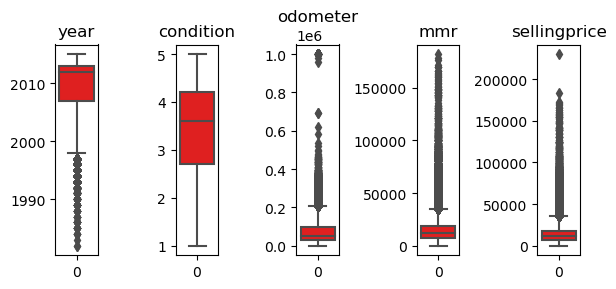

In [14]:
# Melihat penampilan outlier

plt.figure(figsize=(6, 3))
for i in range(0, len(num)):
    plt.subplot(1, len(num), i+1)
    sns.boxplot(dfcar[num[i]], color='red', orient='v')
    plt.title(num[i])
    plt.tight_layout()

Dapat dilihat bahwa `mmr` dan `selling price` memiliki outlier paling banyak, begitu juga dengan kolom odometer dan year. Untuk kuartil dan mediannya pun juga terkesan jauh. Hal ini dapat terjadi karena banyaknya data mobil (500k++) sehingga nilai mmr dan selling price mapun odometer juga sangat bervariasi. Kolom yang terlihat paling normal hanyalah kolom 'condition'. Hasil analisis ini merupakan bentuk visual dari statistik data yang telah kita lakukan sebelumnya pada tahap Data Exploration.

### Distribusi Data (year, condition, odometer, MMR, sellingprice)

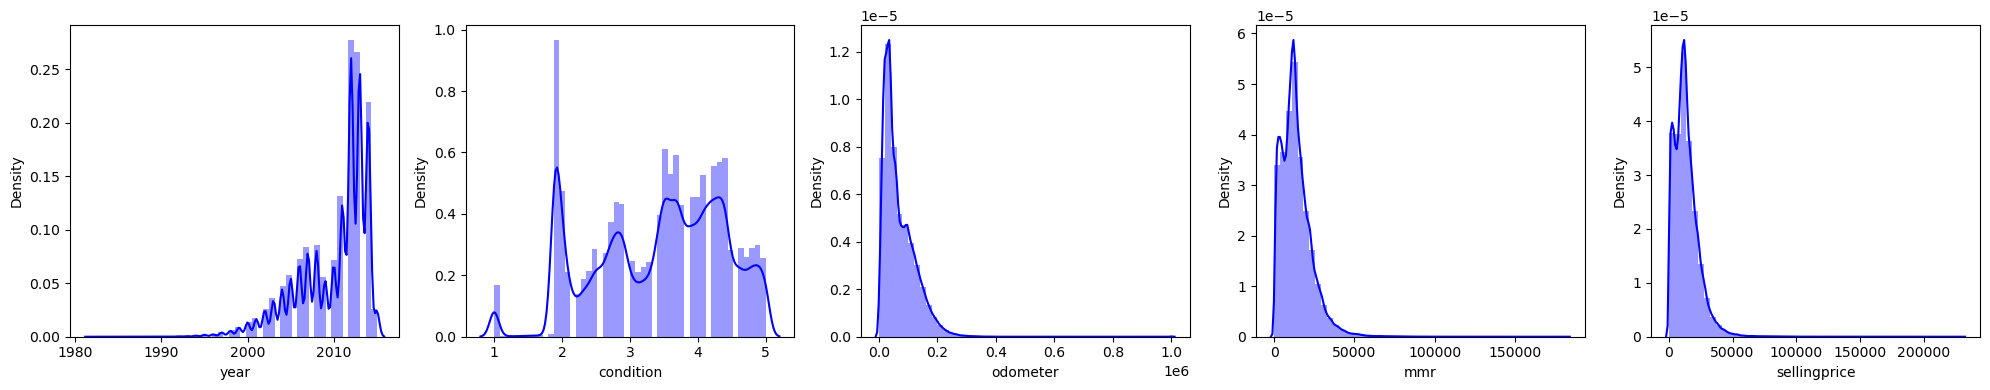

In [15]:
# Melihat grafik distribusi

plt.figure(figsize=(20, 4))
for i in range(0, len(num)):
    plt.subplot(1, 5, i+1)
    sns.distplot(dfcar[num[i]], color='blue')
    plt.tight_layout()

Dari grafik diatas dapat terlihat :
1. Dari kolom `year` kita bisa melihat bahwa penjualan cenderung mengalami peningkatan pada setiap tahunnya dan puncak penjualan berada di antara tahun 2010 hingga 2015. Kita juga bisa melihat bahwa kolom `year` termasuk left-skewed.
2. Pada grafik `condition`, kondisi mobil yang berada di kisaran angka 2 menjadi mayoritas dari kondisi lainnya. Hal ini menunjukkan bahwa kondisi mobil bekas bernilai kurang baik. Namun, tidak sedikit juga kondisi mobil yang bernilai 3 keatas hingga 4. 
3. Untuk `odometer` dapat terlihat bahwa mayoritas berada di angka 0 hingga 0.2 yang artinya odometer berkisar antara 0 hingga 200k. Sedangkan untuk pemakaian mobil diatas 200k terhitung jarang. 
4. Kolom `mmr` dan `sellingprice` terlihat serupa dimana harga jual mobil berkisar di angka 0-50000. 
5. Dari kolom-kolom diatas, kolom `odometer`, `mmr`, dan `sellingprice` termasuk right-skewed.

### Check Nilai Min dan Max

Seperti analisis sebelumnya dimana kita menemukan nilai min dan max yang terkesan tidak masuk akal, maka kita akan mengecek lebih lanjut data yang mengandung nilai tersebut.  

Beberapa kolom tersebut adalah 'odometer', 'mmr', dan 'sellingprice'.

**1. Nilai min dan max dari kolom Odometer**

In [16]:
min_odo = dfcar[dfcar['odometer'] == 1.000]
min_odo

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
697,2013,Nissan,Maxima,3.5 S,Sedan,automatic,1n4aa5apxdc839917,ca,1.000,1.000,gray,black,enterprise vehicle exchange / tra / rental / t...,16950,1000,Tue Jan 13 2015 13:00:00 GMT-0800 (PST)
1000,2012,Chrysler,200,LX,Sedan,automatic,1c3ccbab7cn236141,ca,NaN,1.000,gray,black,santander consumer,10450,1300,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
1723,2012,Mercedes-Benz,M-Class,ML63 AMG,SUV,NaN,4jgda7eb0ca049551,ca,NaN,1.000,NaN,NaN,high bid trading co inc,69000,18500,Thu Dec 18 2014 12:00:00 GMT-0800 (PST)
2082,2011,NaN,NaN,NaN,NaN,automatic,1ftlr1fe5bpa06821,ca,NaN,1.000,white,—,onemain rem/e motorcars,18300,11500,Thu Dec 18 2014 12:00:00 GMT-0800 (PST)
2942,2009,Honda,Civic,LX,Sedan,automatic,2hgfa16579h341583,ca,3.000,1.000,silver,gray,"ahfc/honda lease trust/hvt, inc.",9325,1000,Tue Jun 30 2015 10:00:00 GMT-0700 (PDT)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551550,2002,Saturn,S-Series,SL2,Sedan,NaN,1g8zj54702z304849,wa,2.000,1.000,silver,black,donate for charity,1700,350,Wed Jun 17 2015 05:30:00 GMT-0700 (PDT)
551596,2000,Subaru,Outback,Limited,wagon,automatic,4s3bh6862y7671346,wa,2.000,1.000,black,gray,donate for charity,3025,1050,Wed Jun 17 2015 05:30:00 GMT-0700 (PDT)
553939,2012,Ford,Taurus,SE,sedan,automatic,1fahp2dw4cg130924,ca,3.300,1.000,red,beige,high performance capital,12650,3700,Wed Jun 24 2015 05:30:00 GMT-0700 (PDT)
557280,2001,Dodge,Ram Pickup 1500,ST,regular cab,automatic,1b7hc16x31s209808,ms,1.000,1.000,white,gray,select remarketing group llc/midwest title loans,1750,300,Thu Jun 18 2015 05:02:00 GMT-0700 (PDT)


In [17]:
max_odo = dfcar[dfcar['odometer'] == 999999.000]
max_odo

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
275,2013,Hyundai,Elantra Coupe,GS,Elantra Coupe,automatic,kmhdh6ae8du017422,ca,1.000,999999.000,blue,gray,hyundai motor finance,8025,2500,Tue Jan 27 2015 04:00:00 GMT-0800 (PST)
4626,2003,Chevrolet,Silverado 1500,LS,Extended Cab,automatic,1gcec19v43e225059,ca,2.000,999999.000,gray,gray,800 loan mart,1425,700,Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
13317,2009,Chevrolet,Cobalt,LT,Coupe,automatic,1g1at18h797165360,tx,NaN,999999.000,white,gray,mei finance,3375,400,Thu Dec 18 2014 14:00:00 GMT-0800 (PST)
13480,2009,Dodge,Charger,Base,Sedan,automatic,2b3ka43d49h578284,il,1.000,999999.000,black,gray,santander consumer,3850,1700,Tue Dec 23 2014 13:00:00 GMT-0800 (PST)
13568,2009,Dodge,Charger,Base,Sedan,automatic,2b3ka43dx9h521300,tx,1.000,999999.000,blue,black,santander consumer,4150,5500,Thu Jan 08 2015 14:10:00 GMT-0800 (PST)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489822,2008,Chrysler,300,Touring,sedan,automatic,2c3la53g88h288734,ca,2.700,999999.000,silver,beige,chrysler capital,4325,1200,Tue Jun 02 2015 06:00:00 GMT-0700 (PDT)
490450,2002,Ford,Expedition,Eddie Bauer,suv,automatic,1fmru17l72la49923,tx,2.000,999999.000,black,gray,titlemax/leon valley tx1,600,600,Wed Jun 03 2015 03:20:00 GMT-0700 (PDT)
501462,2011,Volkswagen,Jetta,SEL,sedan,NaN,3vwlx7aj1bm387406,tx,1.000,999999.000,white,tan,santander consumer,8600,1100,Wed Jun 03 2015 05:30:00 GMT-0700 (PDT)
513201,2006,Ford,Taurus,SEL,sedan,automatic,1fafp56u06a197709,oh,1.900,999999.000,gray,gray,car now acceptance co/columbus,175,400,Thu Jun 11 2015 02:00:00 GMT-0700 (PDT)


Dari data min dan max kolom 'odometer' diatas terlihat bahwa data tersebut tidak hanya mengandung nilai min dan max yang jauh tetapi pada kolom lain juga tidak normal. Hal tersebut bisa dilihat dari sample diatas dimana baris min dan max tersebut juga banyak mengandung null value, nilai mmr dan selling price yang rendah, dan kondisi yang tidak bagus. Tidak hanya itu, baris-baris ini juga terhitung banyak yaitu lebih dari 1000 data.

**2. Nilai Min Selling Price**

In [18]:
min_price = dfcar[dfcar['sellingprice'] == 1.000]
min_price

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
7566,2002,Ford,F-350 Super Duty,XLT,Crew Cab,NaN,1ftsw31f52ed16477,ca,2.000,NaN,white,gray,laa leasing,7850,1,Thu Feb 05 2015 04:00:00 GMT-0800 (PST)
48453,2003,Mercedes-Benz,E-Class,E500,Sedan,automatic,wdbuf70j73a269529,ga,2.100,1.000,black,black,peoples credit company inc,7325,1,Tue Jan 06 2015 09:30:00 GMT-0800 (PST)
293223,2014,Ford,E-Series Van,E-250,E-Series Van,automatic,1ftne2ew6eda13643,tx,4.100,31886.000,white,gray,u-haul,20800,1,Thu Feb 12 2015 03:00:00 GMT-0800 (PST)
348252,1995,Isuzu,Rodeo,LS,SUV,NaN,4s2cm58v9s4375559,va,1.000,254132.000,red,gray,automotive remarketing inc,375,1,Wed Mar 04 2015 01:05:00 GMT-0800 (PST)


Nilai min dari selling price yang bernilai 1, terdapat 4 data dari keseluruhan dataset. Hal ini juga perlu menjadi catatan dimana hal ini terkesan tidak masuk akal.

**3. Nilai Min dari MMR**

In [19]:
min_mmr = dfcar[dfcar['mmr'] == 25.000]
min_mmr.sample(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
130627,2002,Chevrolet,Malibu,Base,Sedan,automatic,1g1nd52j12m639067,fl,1.900,284296.000,red,gray,petes auto detailing auto sales llc,25,300,Wed Jan 14 2015 07:00:00 GMT-0800 (PST)
95277,1997,Ford,Taurus,LX,Sedan,automatic,1falp53s7vg148069,fl,2.000,286868.000,gray,gray,national charity services,25,400,Wed Jan 07 2015 09:15:00 GMT-0800 (PST)
438409,2000,Ford,Expedition,XLT,SUV,NaN,1fmru1666yla22376,md,1.000,304300.000,silver,black,select remarketing group llc/anderson financial,25,250,Tue May 19 2015 06:00:00 GMT-0700 (PDT)
140359,2000,Chrysler,LHS,Base,Sedan,automatic,2c3hc56g3yh231210,nc,1.900,223937.000,blue,beige,hendrick motors of charlotte,25,650,Wed Jan 14 2015 06:30:00 GMT-0800 (PST)
557826,2000,Buick,LeSabre,Limited,sedan,NaN,1g4hr54k0yu204587,fl,2.400,269021.000,white,red,courtesy toyota of brandon,25,400,Thu Jun 18 2015 09:20:00 GMT-0700 (PDT)


Dari data diatas dimana nilai mmr hanya 25, juga terdapat kejanggalan pada kolom yang lainnya. Yaitu, banyak terdapat null value, nilai sellingprice yang tergolong kecil, kondisi yang tidak bagus.

### Data Insight
Beberapa data insight lainnya yang didapat dari univariate analysis

In [20]:
# Mengelompokan berdasarkan make (merk atau brand)
top_make = dfcar.groupby('make').size().sort_values(ascending= False).reset_index(name='count')
top_make

,make,count
0,Ford,93554
1,Chevrolet,60197
2,Nissan,53946
3,Toyota,39871
4,Dodge,30710
...,...,...
91,chev truck,1
92,ford tk,1
93,airstream,1
94,hyundai tk,1


Terlihat bahwa merk mobil paling favorit adalah Ford, lalu selanjutnya disusul oleh Chevrolet, Nissan, Toyota, Dodge, dst. Yang uniknya adalah perbedaan mobil-mobil n-teratas dan n-terbawah sangatlah jauh dimana n-teratas menyentuh angka puluhan ribu sedangkan n-terbawah hanya 1 mobil.

In [21]:
# Mengelompokan berdasarkan model
top_model = dfcar.groupby('model').size().sort_values(ascending= False).reset_index(name='count')
top_model

,model,count
0,Altima,19349
1,F-150,14479
2,Fusion,12946
3,Camry,12545
4,Escape,11861
...,...,...
968,Paseo,1
969,Q3,1
970,Ram Van,1
971,Regency,1


Terlihat bahwa top model mobil bekas adalah Altima dan top 2 adalah F-150. Hal ini juga sama seperti analisis merk mobil sebelumnya dimana selisih n-teratas dan n-terbawah sangatlah jauh.

In [22]:
# Mengelompokan berdasarkan warna mobil dan warna interior
color = dfcar.groupby('color').size().sort_values(ascending= False).reset_index(name= 'count')
interior = dfcar.groupby('interior').size().sort_values(ascending= False).reset_index(name= 'count')

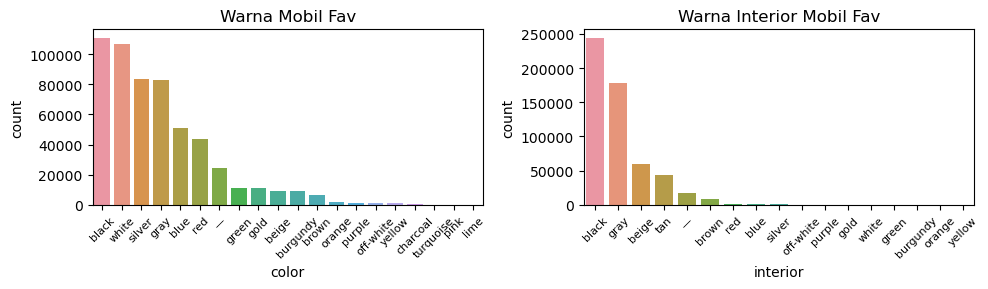

In [23]:
#visualisasi
plt.figure(figsize= (10, 3))

plt.subplot(1,2,1)
sns.barplot(data=color, x='color', y='count')
plt.title('Warna Mobil Fav')
plt.xticks(rotation= 45, size= 8)

plt.subplot(1,2,2)
sns.barplot(data=interior, x='interior', y='count')
plt.title('Warna Interior Mobil Fav')
plt.xticks(rotation= 45, size= 8)
plt.tight_layout()

Dapat terlihat bahwa :
1. Untuk warna mobil dan warna interior mobil paling disukai adalah warna hitam.
2. Terlihat juga bahwa warna interior mobil yang lazim digunakan adalah hitam, abu-abu, beige, dan tan.
3. Terdapat missing value ( - ) pada warna dan interior mobil sehingga perlu dilakukan penanganan pada tahap berikutnya.

## MULTIVARIATE ANALYSIS

### Melihat Korelasi Antar Fitur Numerik

In [13]:
dfcar.corr()

,year,condition,odometer,mmr,sellingprice
year,1.000,0.551,-0.773,0.597,0.586
condition,0.551,1.000,-0.539,0.485,0.539
odometer,-0.773,-0.539,1.000,-0.588,-0.582
mmr,0.597,0.485,-0.588,1.000,0.984
sellingprice,0.586,0.539,-0.582,0.984,1.000


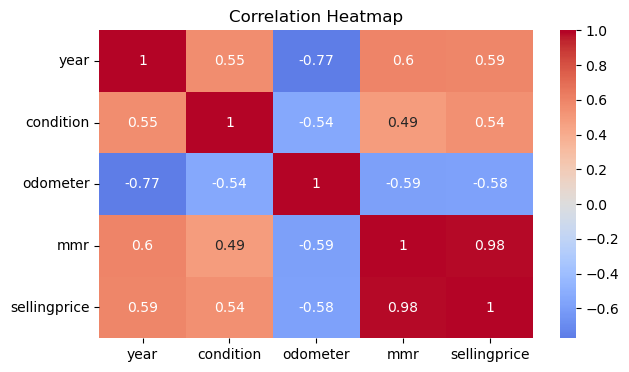

In [25]:
# Plot korelasi heatmap
corr_matrix = dfcar[num].corr()
plt.figure(figsize=(7, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

1. Korelasi antara 'year' dan 'sellingprice' adalah positif, menunjukkan bahwa semakin baru mobil, semakin tinggi harga jualnya.

2. Kolom 'condition' memiliki korelasi positif dengan 'sellingprice', yang berarti semakin baik kondisi mobil, semakin tinggi harga jualnya.

3. Kolom 'odometer' memiliki korelasi negatif dengan 'sellingprice', menunjukkan bahwa semakin sedikit jarak tempuh, semakin tinggi harga jualnya.

4. Kolom 'mmr' memiliki korelasi positif yang cukup kuat dengan 'sellingprice', menunjukkan bahwa harga jual yang diprediksi oleh MMR memiliki korelasi yang baik dengan harga jual aktual.  

5. Kolom ‘Year’ dan ‘Odometer’ juga menunjukkan korelasi negative yang cukup tinggi, artinya mobil keluaran terbaru memiliki odometer yang cenderung kecil

### Korelasi MMR dan Selling Price

Seperti hasil analisis sebelumnya yang menunjukkan bahwa nilai MMR dan Selling Price memiliki kemiripan yang tinggi, maka kita akan coba memvisualisasikan bagaimana hubungan keduanya.

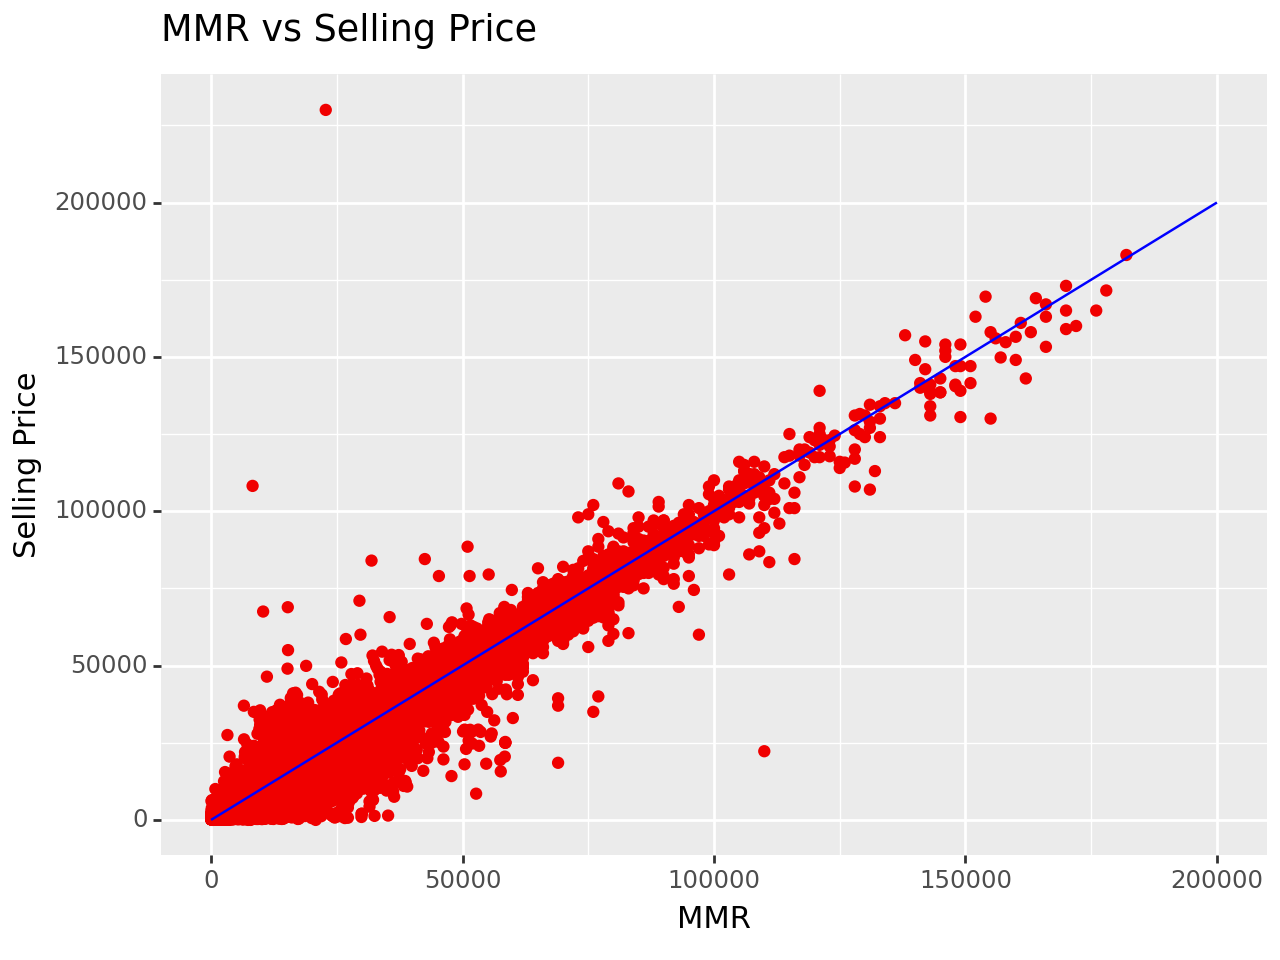

<Figure Size: (640 x 480)>

In [26]:
from plotnine import *

# Visualisasi MMR dan Selling Price
(ggplot(dfcar)
 + aes(x ='mmr', y ='sellingprice') 
 + geom_point(color='#f00000')
 + labs(title='MMR vs Selling Price', x='MMR', y='Selling Price')
 + annotate(geom = "segment", x = 0, xend = 200000, y = 0, yend = 200000, color='blue')
)

Grafik diatas menunjukkan bagaimana persebaran selling price terhadap MMR.  
MMR merupakan singkatan dari Manhiem Market Report yaitu sebuah spesific report yang menjadi indikator wholesale price untuk penjualan kendaraan. Perhitungan harga didasarkan pada lebih dari 10 juta transaksi penjualan selama 13 bulan sebelumnya dengan harga yang tepat oleh penjualan kendaraan nyata di Manheim auction houses. 
Sehingga, bisa dikatakan bahwa MMR layak untuk dijadikan acuan harga.

### Korelasi Condition dan MMR Berdasar Tahun

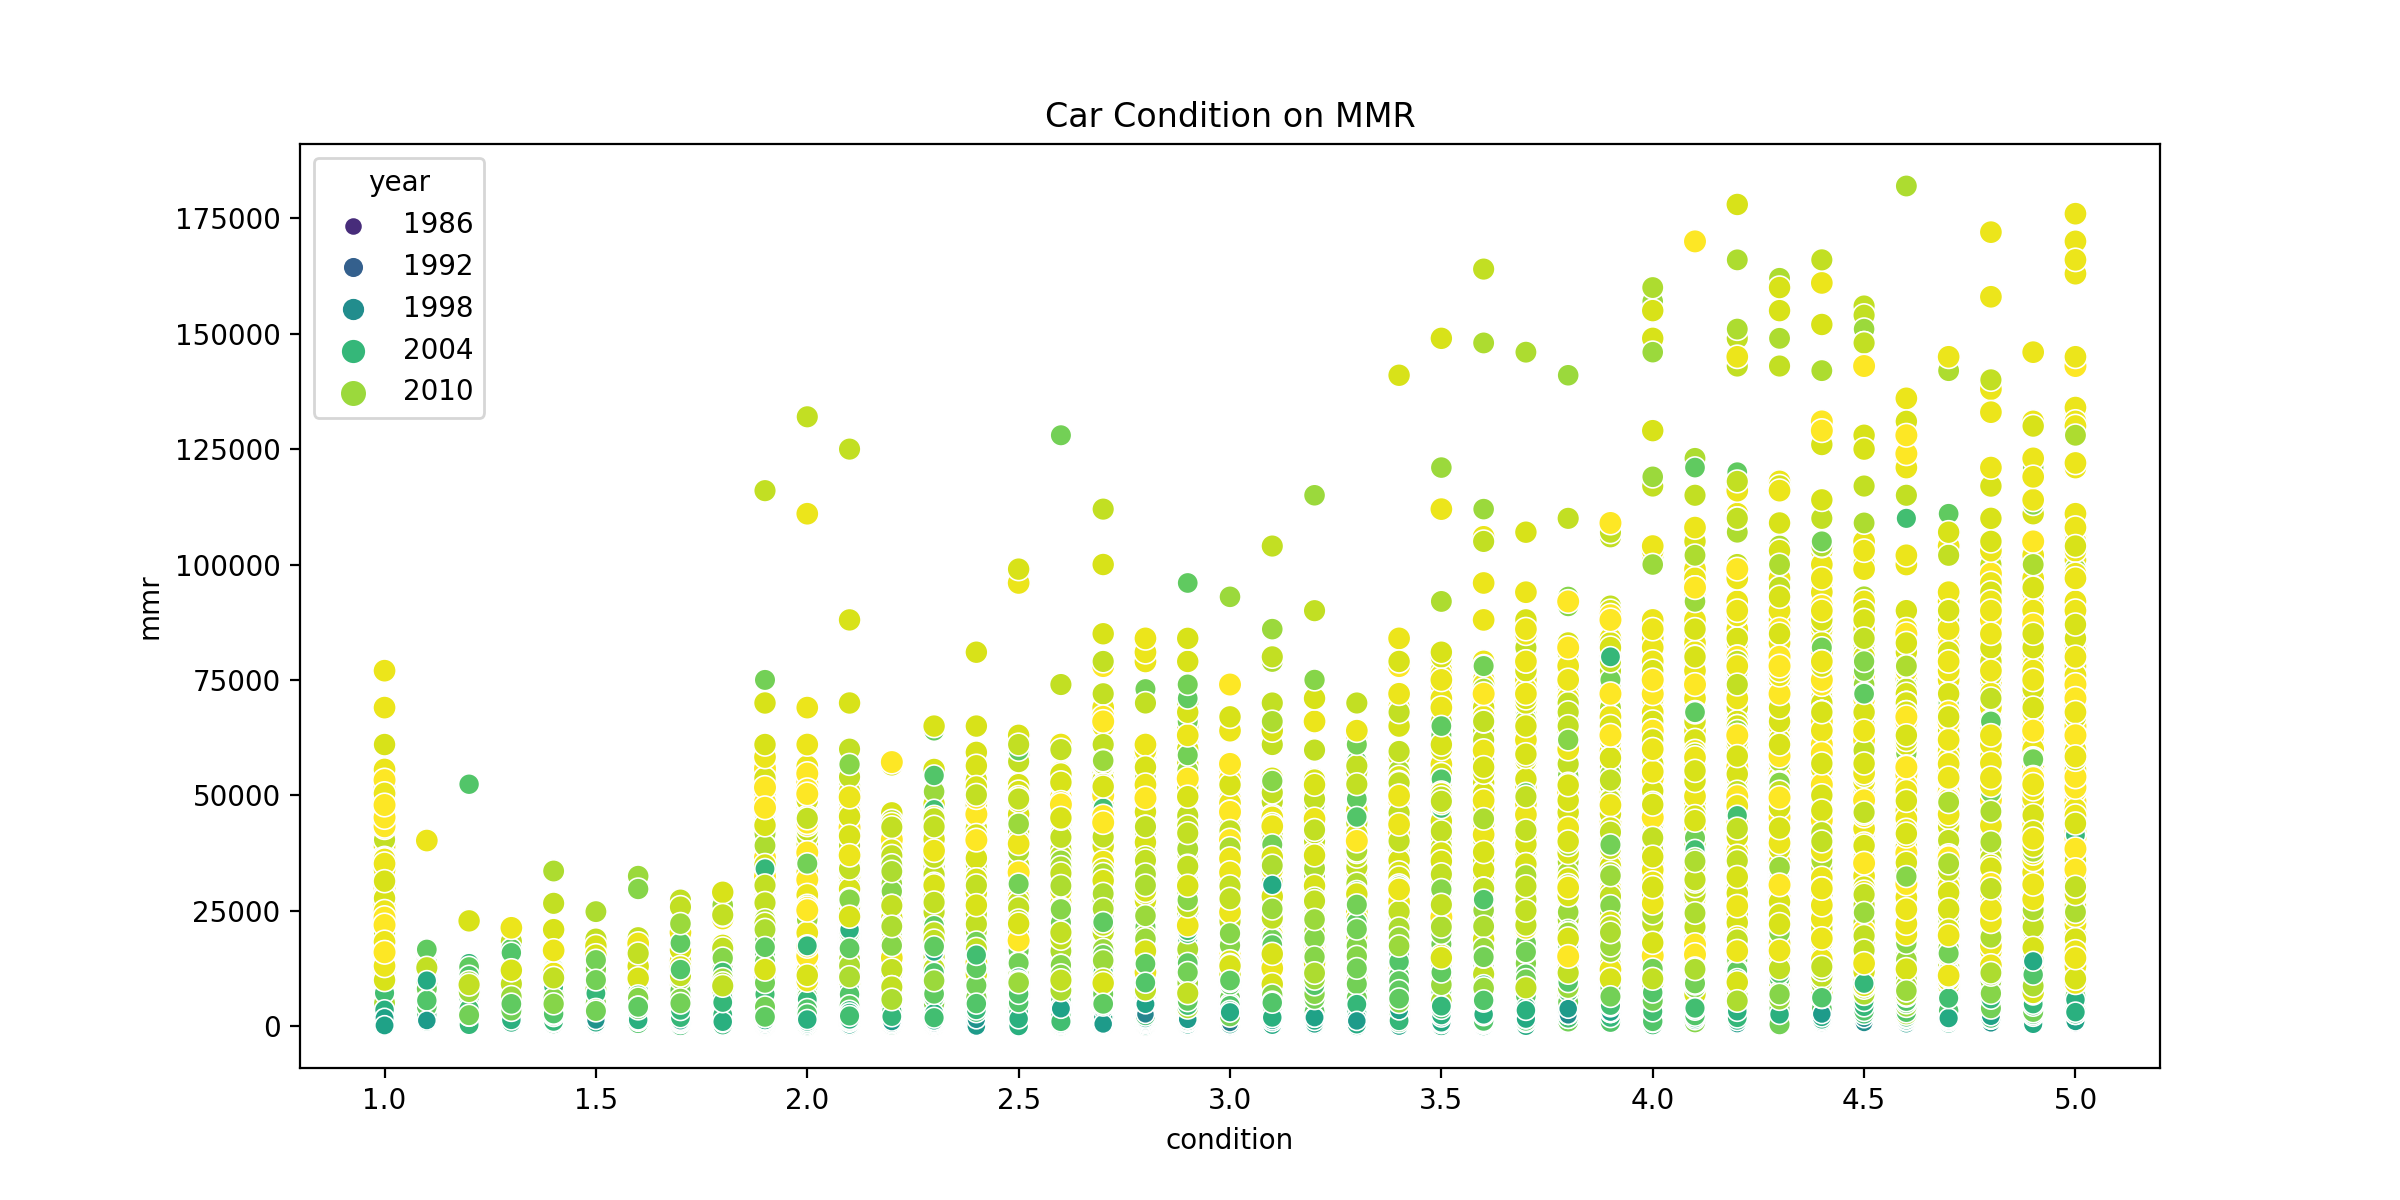

In [27]:
# Visualisasi Harga Jual Terhadap Kondisi Mobil 

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=dfcar, x='condition', y='mmr', hue='year', size= 'year', palette='viridis')
plt.title('Car Condition on MMR')
plt.show()

Dari grafik diatas dapat disimpulkan bahwa pada setiap rentang kondisi mobil dengan mmr yang relatif rendah, terdapat mobil keluaran tahun 2004 keatas. Hal itu bisa mengindikasikan bahwa banyak mobil keluaran tahun 2004 yang dijual bekas. 
Selain itu, produksi mobil sejak 2010 mengalami kenaikan pada kondisi nya dan mmr yang semakin tinggi pula. Hal tersebut menunjukkan bahwa mmr memiliki pengaruh kuat terhadap bagus nya kondisi dan tahun produksi mobil.  

### Korelasi State Terhadap MMR

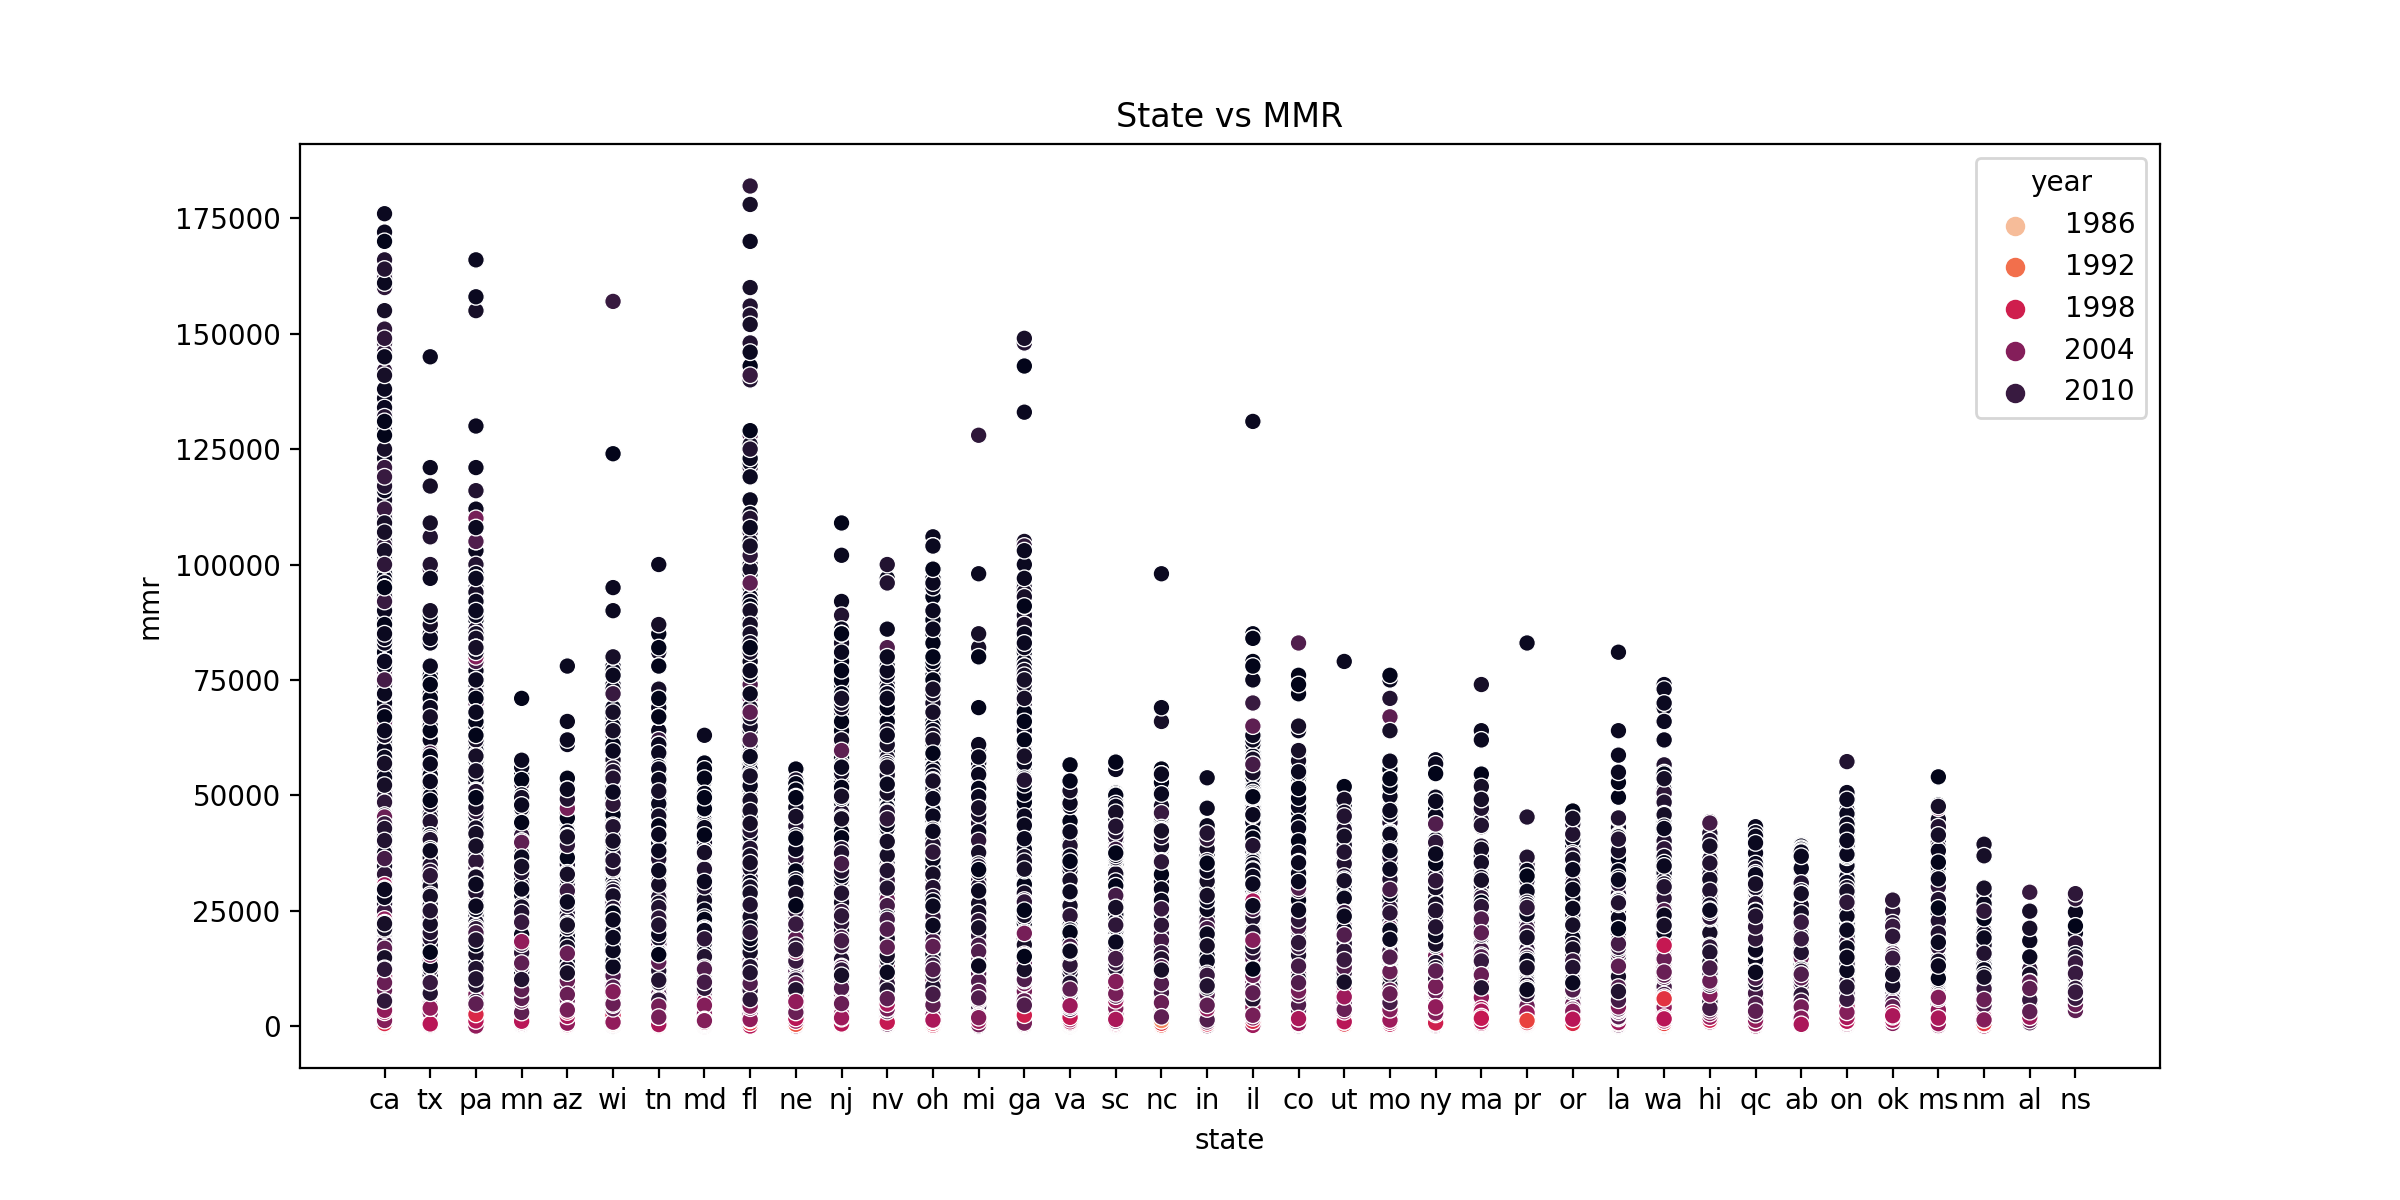

In [28]:
# Visualisasi State terhadap Jumlah Mobil

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(data=dfcar, x='state', y='mmr', hue='year', palette='rocket_r')
plt.title('State vs MMR')
plt.show()

Jika dilihat dari hasil visualisasi diatas, terlihat bahwa pembelian mobil terbanyak berasal dari Florida, lalu California, Pennysilvania, dan Ohio. Di state manapun di US, semakin baru tahun produksi mobil maka mmr juga semakin tinggi. Namun, tidak sedikit juga mobil yang diproduksi pada tahun 2004 yang memiliki mmr yang tinggi.  Selain itu, terlihat juga beberapa outlier mmr yang berasal dari beberapa state. 

Secara keseluruhan, fitur state tidak menunjukkan korelasi yang signifikan. Hal ini mungkin disebabkan oleh platform online yang memungkinkan pembeli berasalh dari daerah manapun.

----------

# Data Preparation

----

## Data Cleansing

### Dropping

**Duplicated Rows**

Pada tahap Data Exploration sebelumnya, terlihat bahwa tidak ada duplicate rows sehingga tidak perlu penanganan.

**Rows with Extreme Values**

Pada tahap EDA sebelumnya, kita menemukan baris-baris yang memiliki outliers ekstrim dan tidak masuk akal. Maka, di tahap data cleaning ini kita akan menghapus baris-baris tersebut.

In [7]:
# Drop min odo
i_min_odo = dfcar[((dfcar.odometer == 1.000))].index
dfcar = dfcar.drop(i_min_odo)

In [8]:
# Drop max odo
i_max_odo = dfcar[((dfcar.odometer == 999999.000))].index
dfcar = dfcar.drop(i_max_odo)

In [9]:
# Drop min sellingprice
i_min_price = dfcar[((dfcar.sellingprice == 1.000))].index
dfcar = dfcar.drop(i_min_price)

In [10]:
# Drop min mmr
i_min_mmr = dfcar[((dfcar.sellingprice == 25.000))].index
dfcar = dfcar.drop(i_min_mmr)

In [11]:
dfcar.shape

(557421, 16)

**Irrelevant Features**

Beberapa fitur terlihat kurang relevan dan unique value yang dimiliki terlalu luas seperti yang sudah kita analisis sebelumnya. Sehingga diasumsikan bahwa fitur tersebut tidak memiliki pola tertentu. Fitur tersebut adalah `vin`, `sellingprice` (korelasi tinggi-redundan), `color`, `interior`, `seller`, `state` yang akan dihapus.

In [12]:
dfcar = dfcar.drop(['vin', 'color', 'interior', 'seller', 'sellingprice', 'state'], axis=1)
dfcar.head(3)

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5.000,16639.000,20500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5.000,9393.000,20800,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,4.500,1331.000,31900,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)


### Handle Unique Values

Pada beberapa fitur terdapat banyak sekali unique values seperti yang sudah dieksplor sebelumnya. Kita akan menghandle unique values yang tidak seragam tersebut menjadi lower case untuk mendapatkan value yang bernilai sama. 

In [13]:
def content_consistent(df):
    cols = df.select_dtypes(object).columns.difference(['saledate'])
    df[cols] = df[cols].apply(lambda x: x.str.lower())
    return df

dfcar = content_consistent(dfcar)

In [14]:
c = ['make', 'model', 'trim', 'body']

dfcar[c].describe()

,make,model,trim,body
count,547189,547091,546844,544311
unique,66,850,1898,45
top,ford,altima,base,sedan
freq,93838,19323,55648,240711


Setelah dilakukan pembersihan data dengan menyamaratakan penulisan string, maka terlihat hasilnya dimana:  
a. `make` yang awalnya 96 kini hanya 66 unique values  
b. `model` yang awalnya 973 kini hanya 851 unique values  
c. `trim` yang awalnya 1975 kini hanya 1901 unique values  
d. `body` yang awalnya 86 kini hanya 45 unique values  
e. Semua value sudah menjadi lower case

### Handle Missing Values

Terdapat 9 fitur yang memiliki Null value, yaitu `make`, `model`, `trim`, `body`, `transmission`, `condition`, `odometer`, `color`, `interior`. 

Namun, dikarenakan fitur color dan interior telah dihapus, maka kita hanya perlu meng-handle fitur lainnya.  
1. `make`, `model`, `trim`, `body` akan diisi dengan nilai modus.  
2. `transmission` akan diisi dengan value "manual" untuk mencegah terjadinya imbalanced class yang terlalu jauh.  
3. `condition` yang memiliki persebaran data yang lumayan normal, maka akan diisi dengan nilai mean. 
4. `odometer` yang hanya memiliki 94 null values, kita akan menghapusnya. 

In [15]:
mode_value = dfcar['make'].mode()[0]
dfcar['make'].fillna(mode_value, inplace=True)

In [16]:
mode_value = dfcar['model'].mode()[0]
dfcar['model'].fillna(mode_value, inplace=True)

In [17]:
mode_value = dfcar['trim'].mode()[0]
dfcar['trim'].fillna(mode_value, inplace=True)

In [18]:
mode_value = dfcar['body'].mode()[0]
dfcar['body'].fillna(mode_value, inplace=True)

In [19]:
dfcar['transmission'].fillna('manual', inplace=True)

In [20]:
dfcar['condition'] = dfcar['condition'].fillna(dfcar['condition'].mean())

In [21]:
dfcar.dropna(axis=0, inplace=True)
dfcar.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
condition       0
odometer        0
mmr             0
saledate        0
dtype: int64

### Handle Outliers

In [27]:
df_clean = dfcar.copy()

In [28]:
def outlier_del(df, column, mode):
    q1 = df.iloc[:,column].quantile(0.25)
    q3 = df.iloc[:,column].quantile(0.75)
    iqr = q3-q1
    lower_tail = q1 - (1.5 * iqr)
    upper_tail = q3 + (1.5 * iqr)
    nama_kolom = df.columns[column]
    jumlah_outliers = df[(df.iloc[:,column] <= lower_tail)|(df.iloc[:,column] >= upper_tail)].iloc[:,column].count()
    total_row = df.iloc[:,column].count()
    persentase_outliers = round(((jumlah_outliers/total_row)*100),2)
    if mode == 'summary':
        return print('Jumlah Outliers pada kolom ', nama_kolom, ' :', jumlah_outliers, ' dan persentase outliers:', persentase_outliers, '%')
    elif mode == 'df':
        return df[(df.iloc[:,column] >= lower_tail)&(df.iloc[:,column] <= upper_tail)]
    else :
        return print('periksa mode yang diinputkan')

In [29]:
# Memeriksa presentase outlier setiap kolom
column = [0, 7, 8]

for i in range(0, len(column)):
    outlier_del(df_clean, column[i], 'summary')

Jumlah Outliers pada kolom  year  : 6033  dan persentase outliers: 1.08 %
Jumlah Outliers pada kolom  odometer  : 10289  dan persentase outliers: 1.85 %
Jumlah Outliers pada kolom  mmr  : 16307  dan persentase outliers: 2.93 %


In [30]:
# Menghapus outliers

df_clean = df_clean[df_clean.index.isin(outlier_del(dfcar, 0, 'df').reset_index()['index'])]
df_clean = df_clean[df_clean.index.isin(outlier_del(dfcar, 7, 'df').reset_index()['index'])]
df_clean = df_clean[df_clean.index.isin(outlier_del(dfcar, 8, 'df').reset_index()['index'])]
df_clean.shape

(527815, 10)

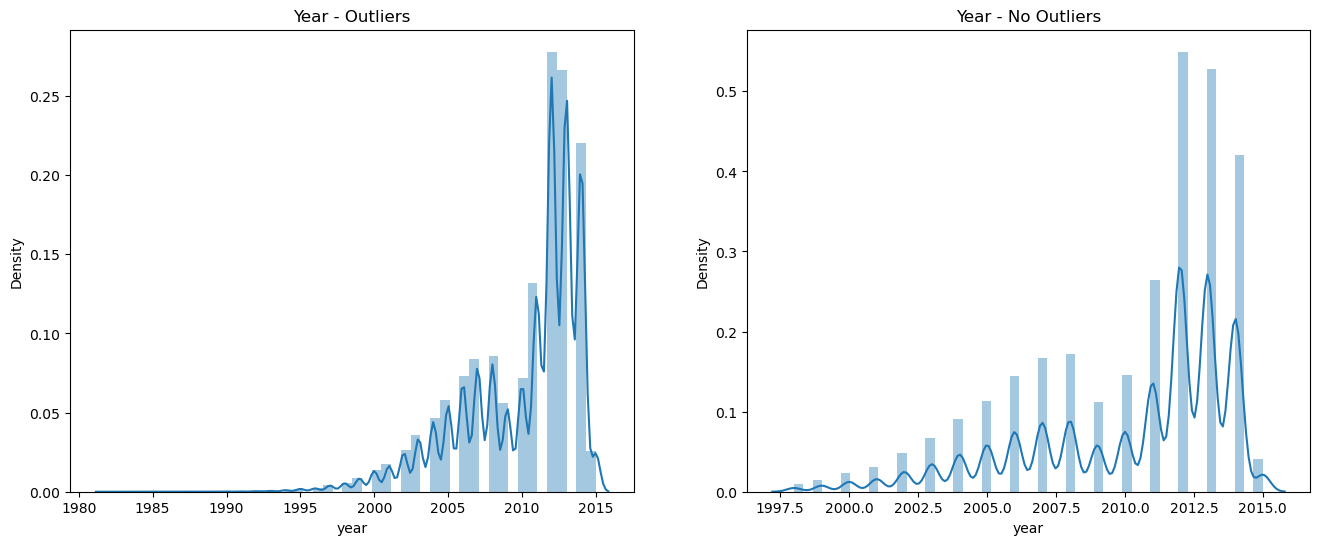

In [32]:
# Membuat Plot Untuk Membandingkan dengan kondisi sebelum penghapusan outlier
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(dfcar.year)
plt.title('Year - Outliers')
plt.subplot(1, 2, 2)
sns.distplot(df_clean.year)
plt.title('Year - No Outliers')
plt.show()

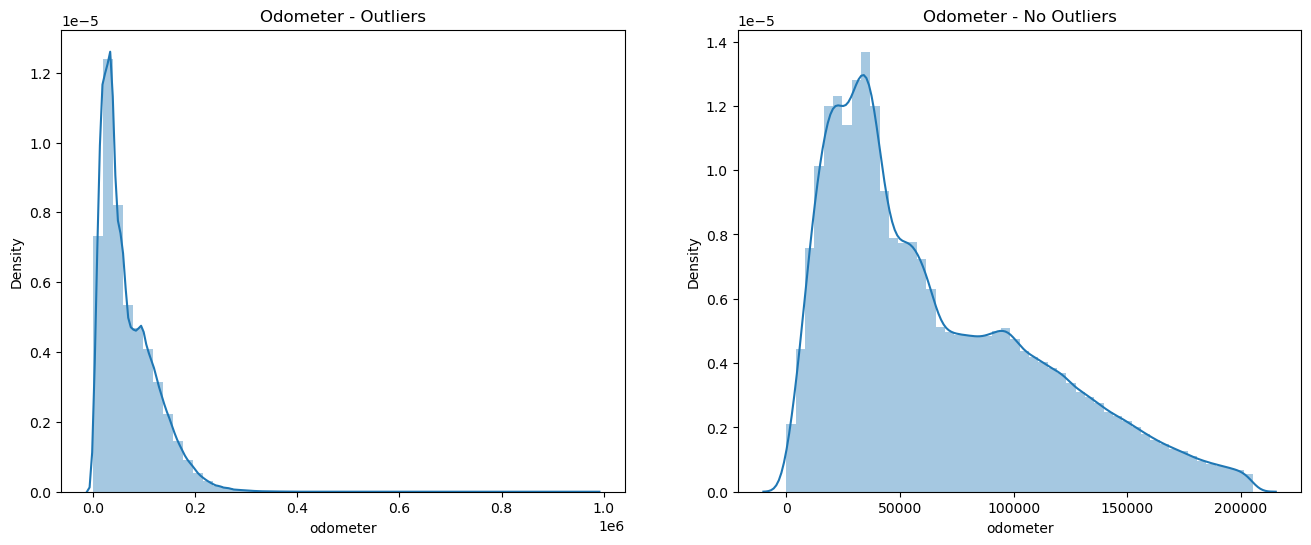

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(dfcar.odometer)
plt.title('Odometer - Outliers')
plt.subplot(1, 2, 2)
sns.distplot(df_clean.odometer)
plt.title('Odometer - No Outliers')
plt.show()

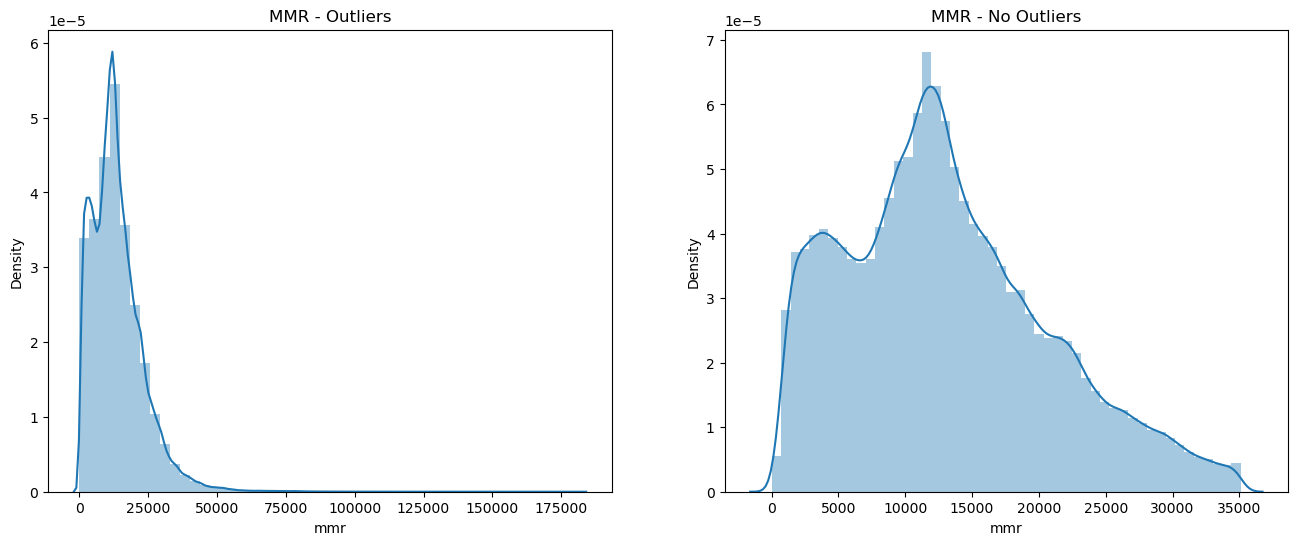

In [34]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(dfcar.mmr)
plt.title('MMR - Outliers')
plt.subplot(1, 2, 2)
sns.distplot(df_clean.mmr)
plt.title('MMR - No Outliers')
plt.show()

## Feature Engineering

### Feature Extraction

#### Day of Week - Is Weekend
Menambahkan fitur baru 'day' dengan mengambil hari pada fitur `saledate`.

In [35]:
timeget = []
for i in df_clean['saledate'].str.split():
    time_split = i[:5]
    date_string = ' '.join(time_split)
    timeget.append(date_string)
df_clean['datetime'] =  pd.to_datetime(timeget)

In [36]:
# Mengubah tipe data object ke datetime
df_clean['datetime'] =  pd.to_datetime(timeget)
df_clean['day'] = df_clean['datetime'].apply(lambda time: time.dayofweek)

# Mapping spesific day of week
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df_clean['day'] = df_clean['day'].map(dmap)
df_clean['is_weekend'] = df_clean['day of week'].apply(lambda x: 1 if x in ['Sat', 'Sun'] else 0)
df_clean.head()

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate,datetime,day
0,2015,kia,sorento,lx,suv,automatic,5.000,16639.000,20500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue
1,2015,kia,sorento,lx,suv,automatic,5.000,9393.000,20800,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue
2,2014,bmw,3 series,328i sulev,sedan,automatic,4.500,1331.000,31900,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00,Thu
3,2015,volvo,s60,t5,sedan,automatic,4.100,14282.000,27500,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015-01-29 04:30:00,Thu
5,2015,nissan,altima,2.5 s,sedan,automatic,1.000,5554.000,15350,Tue Dec 30 2014 12:00:00 GMT-0800 (PST),2014-12-30 12:00:00,Tue


#### Made In

Menyederhanakan value pada fitur `make` dengan mengkategorikan merk mobil sesuai asal negara pembuat nya.

In [37]:
df_clean['make'].unique()

array(['kia', 'bmw', 'volvo', 'nissan', 'chevrolet', 'audi', 'ford',
       'hyundai', 'buick', 'acura', 'cadillac', 'infiniti', 'jeep',
       'lexus', 'mitsubishi', 'mercedes-benz', 'mazda', 'mini', 'lincoln',
       'land rover', 'jaguar', 'volkswagen', 'toyota', 'subaru', 'scion',
       'dodge', 'fiat', 'chrysler', 'honda', 'gmc', 'ram', 'smart',
       'pontiac', 'saturn', 'mercury', 'hummer', 'landrover', 'mercedes',
       'gmc truck', 'porsche', 'saab', 'suzuki', 'oldsmobile', 'isuzu',
       'maserati', 'mazda tk', 'hyundai tk', 'mercedes-b', 'vw', 'daewoo',
       'chev truck', 'ford tk', 'plymouth', 'ford truck', 'airstream',
       'dot'], dtype=object)

In [41]:
# Brand mobil berdasarkan negara pembuat

us_made = ['chevrolet', 'ford', 'buick', 'cadillac', 'jeep', 'dodge', 'chrysler', 'ram', 'scion', 'pontiac', 'saturn', 'mercury', 'hummer', 'gmc', 'gmc truck', 'oldsmobile', 'ford tk', 'ford truck', 'lincoln', 'plymouth']
germany_made = ['bmw', 'audi', 'mercedes-benz', 'porsche', 'smart', 'chev truck', 'volkswagen', 'mercedes-b', 'mercedes', 'vw']
japan_made = ['nissan', 'acura', 'lexus', 'infiniti', 'mitsubishi', 'mazda', 'toyota', 'subaru', 'honda', 'suzuki', 'isuzu', 'mazda tk']
uk_made = ['mini', 'land rover', 'jaguar','landrover']
italy_made = ['fiat', 'maserati']
korea_made = ['kia', 'hyundai', 'hyundai tk', 'daewoo']
swedia_made = ['volvo', 'saab']

In [42]:
made_in = []

for maker in df_clean['make']:
    if maker in us_made:
        country = 'US'
    elif maker in germany_made:
        country = 'DEU'
    elif maker in japan_made:
        country = 'JPN'
    elif maker in uk_made:
        country = 'UK'
    elif maker in italy_made:
        country = 'ITA'
    elif maker in korea_made:
        country = 'KOR'
    elif maker in sweden_made:
        country = 'SWE'
    else:
        country = 'others'
    
    made_in.append(country)

In [44]:
df_clean['made_in'] = made_in

In [45]:
df_clean.head(3)

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate,datetime,day,made_in
0,2015,kia,sorento,lx,suv,automatic,5.000,16639.000,20500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR
1,2015,kia,sorento,lx,suv,automatic,5.000,9393.000,20800,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR
2,2014,bmw,3 series,328i sulev,sedan,automatic,4.500,1331.000,31900,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00,Thu,DEU


#### Body Simplified

Mengkategorikan fitur `body` menjadi lebih sederhana.

In [47]:
# Kategori body mobil

cab = ['crew cab', 'double cab','crewmax cab', 'access cab','king cab','extended cab', 'supercab', 'regular cab','quad cab', 'club cab','xtracab', 'mega cab','regular-cab', 'cab plus 4',  'cab plus']
gtype = ['g coupe', 'g sedan', 'g convertible']
coupe = ['coupe', 'q60 coupe', 'cts-v coupe', 'elantra coupe', 'genesis coupe', 'koup', 'cts coupe', 'g37 coupe']
wagon = ['wagon', 'cts wagon', 'cts-v wagon', 'tsx sport wagon']
suv = ['suv']
van = ['van', 'e-series van', 'promaster cargo van', 'ram van', 'transit van', 'minivan' ]
sedan = ['sedan']
convertible = ['convertible', 'g37 convertible',  'q60 convertible', 'beetle convertible', 'granturismo convertible']
hatchback = ['hatchback']
supercrew = ['supercrew']

In [48]:
body_cat = []

for b in df_clean['body']:
    if b in cab:
        btype = 'cab'
    elif b in gtype:
        btype = 'g-type'
    elif b in coupe:
        btype = 'coupe'
    elif b in wagon:
        btype = 'wagon'
    elif b in suv:
        btype = 'suv'
    elif b in van:
        btype = 'van'
    elif b in sedan:
        btype = 'sedan'
    elif b in convertible:
        btype = 'convertible'
    elif b in hatchback:
        btype = 'hatchback'
    elif b in supercrew:
        btype = 'supercrew'
    else:
        btype = 'others'
    
    body_cat.append(btype)

In [49]:
df_clean['body_type'] = body_cat
df_clean.head(3)

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate,datetime,day,made_in,body_type
0,2015,kia,sorento,lx,suv,automatic,5.000,16639.000,20500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR,suv
1,2015,kia,sorento,lx,suv,automatic,5.000,9393.000,20800,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR,suv
2,2014,bmw,3 series,328i sulev,sedan,automatic,4.500,1331.000,31900,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00,Thu,DEU,sedan


#### Exclusivity
Mengkategorikan mobil berdasarkan tingkat eksklusifitas.

In [50]:
common = ['kia', 'nissan', 'chevrolet', 'ford', 'hyundai', 'buick', 'jeep', 'mitsubishi', 'mazda', 'mini','volkswagen', 
          'toyota', 'subaru', 'scion', 'dodge', 'fiat', 'honda', 'gmc', 'ram', 'smart', 'pontiac',
          'saturn', 'mercury','hummer', 'gmc truck', 'suzuki', 'oldsmobile', 'isuzu', 'geo', 'mazda tk','hyundai tk', 
          'vw', 'daewoo', 'chev truck', 'ford tk', 'plymouth', 'ford truck', 'airstream', 'dot']

mid= ['bmw', 'audi', 'acura', 'lexus', 'infiniti', 'mercedes-benz', 'porsche', 'bentley', 'saab', 'mercedes-b', 'mercedes']

luxury = ['volvo', 'cadillac', 'land rover', 'jaguar','maserati', 'landrover', 'chrysler', 'lincoln']

In [ ]:
exclusivity = []

for cat in df_clean['make']:
    if cat in common:
        exc = 'common'
    elif cat in mid:
        exc = 'mid'
    elif cat in luxury:
        exc = 'luxury'
    else:
        exc = 'others'
    
    exclusivity.append(exc)

In [ ]:
df_clean['exclusivity'] = exclusivity
df_clean.head(3)

#### Model Cluster

In [55]:
from kmodes.kmodes import KModes

# Mengonversi daftar model mobil menjadi DataFrame dengan satu kolom 'model'
model = pd.DataFrame({'model': df_clean['model']})

# Inisialisasi K-Modes dengan jumlah cluster yang diinginkan
km = KModes(n_clusters=10, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(model)
print(clusters)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 466965.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 472653.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 455634.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 464727.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 467445.0
Best run was number 3
[0 0 0 ... 0 0 5]


In [56]:
df_clean['model_cluster'] = clusters
df_clean.head(3)

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate,datetime,day,made_in,body_type,is_luxury_brand,model_cluster
0,2015,kia,sorento,lx,suv,automatic,5.000,16639.000,20500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR,suv,0,0
1,2015,kia,sorento,lx,suv,automatic,5.000,9393.000,20800,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR,suv,0,0
2,2014,bmw,3 series,328i sulev,sedan,automatic,4.500,1331.000,31900,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00,Thu,DEU,sedan,1,0


#### Trim Cluster

In [58]:
trim = pd.DataFrame({'trim': df_clean['trim']})
km = KModes(n_clusters=10, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(trim)

print(clusters)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 386808.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 384837.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 383361.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 398178.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 374926.0
Best run was number 5
[4 4 0 ... 0 2 0]


In [59]:
df_clean['trim_cluster'] = clusters
df_clean.head(3)

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate,datetime,day,made_in,body_type,is_luxury_brand,model_cluster,trim_cluster
0,2015,kia,sorento,lx,suv,automatic,5.000,16639.000,20500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR,suv,0,0,4
1,2015,kia,sorento,lx,suv,automatic,5.000,9393.000,20800,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014-12-16 12:30:00,Tue,KOR,suv,0,0,4
2,2014,bmw,3 series,328i sulev,sedan,automatic,4.500,1331.000,31900,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015-01-15 04:30:00,Thu,DEU,sedan,1,0,0


#### Transmission: Is Automatic

In [60]:
df_clean['is_auto'] = df_clean['transmission'] == 'automatic'
df_clean.sample(3)

,year,make,model,trim,body,transmission,condition,odometer,mmr,saledate,datetime,day,made_in,body_type,is_luxury_brand,model_cluster,trim_cluster,is_auto
534471,2013,gmc,yukon xl,denali,suv,automatic,4.100,76584.000,32000,Tue Jun 16 2015 02:30:00 GMT-0700 (PDT),2015-06-16 02:30:00,Tue,US,suv,0,0,6,True
158766,2012,ford,escape,xlt,suv,automatic,1.900,33357.000,14750,Thu Jan 22 2015 02:00:00 GMT-0800 (PST),2015-01-22 02:00:00,Thu,US,suv,0,4,0,True
208023,2014,ford,fusion,se,sedan,automatic,2.500,24507.000,15800,Tue Jan 27 2015 01:30:00 GMT-0800 (PST),2015-01-27 01:30:00,Tue,US,sedan,0,0,8,True


Setelah semua fitur menjadi numerik, selanjutnya kita bisa menghapus kolom kategori awal dan kolom yang tidak diperlukan.

In [61]:
df_clean = df_clean.drop(['make', 'model', 'trim', 'body', 'transmission', 'saledate', 'datetime', 'day'], axis=1)
df_clean.sample(3)

,year,condition,odometer,mmr,made_in,body_type,is_luxury_brand,model_cluster,trim_cluster,is_auto
176906,2009,4.100,70401.000,13050,JPN,van,0,0,0,True
195365,2007,2.000,102060.000,5400,US,suv,0,0,1,True
80693,2011,3.100,34142.000,11700,US,sedan,0,0,0,False


In [62]:
df_clean.dtypes

year                 int64
condition          float64
odometer           float64
mmr                  int64
made_in             object
body_type           object
is_luxury_brand      int64
model_cluster       uint16
trim_cluster        uint16
is_auto               bool
dtype: object

### Feature Encoding

#### One-Hot Encoding : Made In

In [ ]:
df_prep = df_clean.copy

In [ ]:
# Melakukan One Hot Encoding karena data tidak memiliki urutan
df_prep = pd.get_dummies(df_prep, columns=['made_in'])

#### One-Hot Encoding : Body Type

(lakukan hal yang sama. OHE pada body type)

#### Label Encoder : Exclusivity

In [ ]:
# Melakukan Label Encoding karena data memiliki tingkat urutan
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

kategori_mapping = {
    'others': 0,
    'common': 1,
    'mid': 2,
    'luxury': 3
}

df_prep['exclusivity_encoded'] = df_prep['exclusivity'].map(kategori_mapping)
df_prep.sample(3)

Beberapa feature sudah ditambahkan untuk menemukan pola-pola tersembunyi dalam data.  
Selanjutnya, untuk sementara sebelum dilakukan label encoding, kita akan menampilkan fitur-fitur yang memiliki korelasi tinggi melalui confusion matrix. (tampilkan melalui confusion matrix)

### Feature Selection

(drop kolom-kolom yang tidak relevan, sebelum masuk ke splitting data)

## Train-Test Split

(split data)

## Pre-Processing

(Normalisasi data)